In [215]:
import pandas as pd
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

os.chdir("C:/Users/jerem/OneDrive/Documents/rocketleague_ml")
file_name = "replay"
player_name = "CallMeBigSenior"
round = 1

processed_file = f"data/processed/pkl/replay.pkl"

with open(processed_file, "rb") as f:
    game = pickle.load(f)

In [216]:
def get_positioning_for_player_by_round(round: int):
    player = None
    for p in game.players.values():
        if p.name == player_name:
            player = p
            break

    if not player:
        raise ValueError("Could not find player {player_name}")

    if not player.car:
        raise ValueError("Could not find player car {player_name}")

    positioning = pd.DataFrame(player.car.updates_by_round[round])
    positioning.head()

    loc_positioning = pd.json_normalize(positioning["location"]) # type: ignore
    loc_positioning.columns = [f"location_{c}" for c in loc_positioning.columns]

    # Expand 'rotation' into its own columns
    rot_positioning = pd.json_normalize(positioning["rotation"]) # type: ignore
    rot_positioning.columns = [f"rotation_{c}" for c in rot_positioning.columns]

    # Expand 'linear_velocity'
    linvel_positioning = pd.json_normalize(positioning["linear_velocity"]) # type: ignore
    linvel_positioning.columns = [f"linear_velocity_{c}" for c in linvel_positioning.columns]

    # Same for angular_velocity (if not all None)
    angvel_positioning = pd.json_normalize(positioning["angular_velocity"]) # type: ignore
    angvel_positioning.columns = [f"angular_velocity_{c}" for c in angvel_positioning.columns]

    # Concatenate back
    positioning = pd.concat(
        [positioning.drop(["location", "rotation", "linear_velocity", "angular_velocity"], axis=1),
        loc_positioning, rot_positioning, linvel_positioning, angvel_positioning],
        axis=1
    )
    positioning["location_x"] = -positioning["location_x"]
    # positioning["location_y"] = -positioning["location_y"]
    return positioning

# XY Positioning

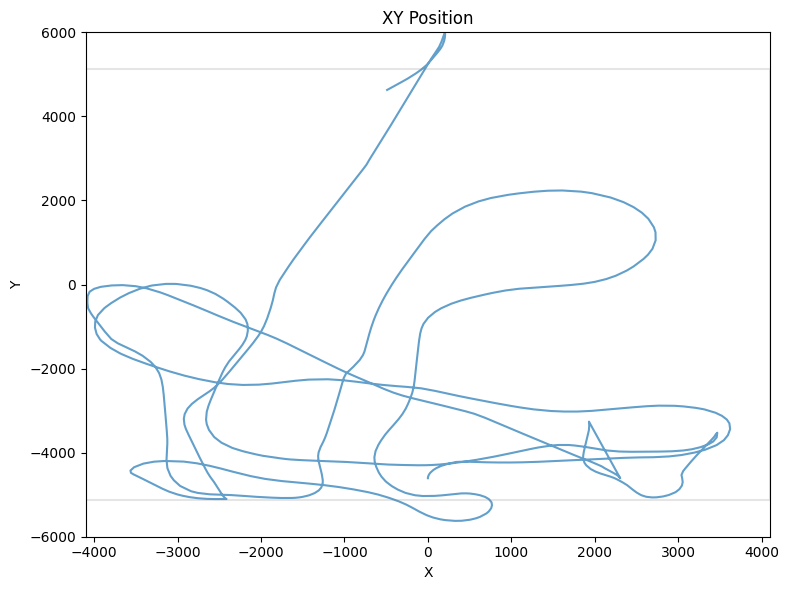

In [217]:

round_positioning = get_positioning_for_player_by_round(round)

field_x = [-4096, 4096, 4096, -4096, -4096]
field_y = [-5120, -5120, 5120, 5120, -5120]

fig, ax = plt.subplots(figsize=(8, 6))

# plot player positions
ax.plot(round_positioning["location_x"], round_positioning["location_y"], alpha=0.7)

# add field outline
ax.plot(field_x, field_y, color="grey", alpha=0.2)

ax.set_title("XY Position")
ax.set_xlabel("X")
ax.set_ylabel("Y")

# optional: set bounds
ax.set_xlim(field_x[0], field_x[1])
ax.set_ylim(-6000, 6000)

plt.tight_layout()
plt.show()


In [218]:

dense = pd.DataFrame({"time": [frame["time"] for frame in game.frames], "delta": [frame["delta"] for frame in game.frames], "active": [frame["active"] or False for frame in game.frames]})
dense.set_index("time", drop=False, inplace=True)

# --- ball ---
ball_ser = pd.DataFrame(
    {u["time"]: (u["location"]["x"], u["location"]["y"], u["location"]["z"])
     for u in game.ball.updates_by_round[round]}
).T.rename(columns={0: "ball_x", 1: "ball_y", 2: "ball_z"})

# reindex onto master frame list
ball_ser = ball_ser.reindex(dense.index, method="ffill")
for col in ball_ser.columns:
    dense[col] = ball_ser[col]

# --- players ---
for player in game.players.values():
    if not player.car:
        continue
    prefix = player.name + "_"
    if player.name == player_name:
        prefix = ""
    player_ser = pd.DataFrame(
        {u["time"]: (u["location"]["x"], u["location"]["y"], u["location"]["z"])
         for u in player.car.updates_by_round[round]}
    ).T.rename(columns={0: f"{prefix}x", 1: f"{prefix}y", 2: f"{prefix}z"})

    player_ser = player_ser.reindex(dense.index, method="ffill")
    for col in player_ser.columns:
        dense[col] = player_ser[col]

# --- drop rows where all position columns are NaN ---
pos_cols = [c for c in dense.columns if c != "time"]

# mask for rows that have at least one position
mask_pos = dense[pos_cols].notna().any(axis=1)

# mask for rows that are active
mask_active = dense["active"] == True

# combined mask
mask = mask_pos & mask_active

# find the first and last "valid" indices
valid_index = mask[mask].index  # Index of rows where mask is True
first_valid = valid_index[0]
last_valid = valid_index[-1]

# slice the DataFrame to keep only that range
dense = dense.loc[first_valid:last_valid].reset_index(drop=True)

# now you can ffill/bfill safely
dense = dense.ffill().bfill()

# --- distance to ball ---
dense["distance_to_ball"] = np.sqrt(
    (dense["x"] - dense["ball_x"]) ** 2 +
    (dense["y"] - dense["ball_y"]) ** 2 +
    (dense["z"] - dense["ball_z"]) ** 2
)

# --- distance to other players ---
for player in game.players.values():
    if player.name == player_name:
        continue
    dense[f"distance_to_{player.name}"] = np.sqrt(
        (dense["x"] - dense[f"{player.name}_x"]) ** 2 +
        (dense["y"] - dense[f"{player.name}_y"]) ** 2 +
        (dense["z"] - dense[f"{player.name}_z"]) ** 2
    )

# --- zone checks ---
max_y = abs(field_y[0])
third_of_y = max_y / 3
dense["offensive_half"] = dense["y"] > 0
dense["defensive_half"] = dense["y"] <= 0
dense["offensive_third"] = dense["y"] >= third_of_y
dense["neutral_third"] = (dense["y"] < third_of_y) & (dense["y"] > -third_of_y)
dense["defensive_third"] = dense["y"] <= -third_of_y

dense.head().T

,0,1,2,3,4
time,21.390148,21.425114,21.46008,21.495043,21.53001
delta,0.034966,0.034966,0.034966,0.034966,0.034966
active,True,True,True,True,True
ball_x,0.0,0.0,0.0,0.0,0.0
ball_y,0.0,0.0,0.0,0.0,0.0
ball_z,93.0,93.0,93.0,93.0,93.0
x,0.0,0.0,0.0,-0.01,-0.01
y,-4608.0,-4607.46,-4607.46,-4596.44,-4596.44
z,17.0,17.01,17.01,17.01,17.01
Tootew_x,-256.0,-256.0,-256.0,-255.97,-255.97


In [219]:
dense.tail().T

,9629,9630,9631,9632,9633
time,377.11,377.14493,377.17987,377.2148,377.24976
delta,0.034966,0.034966,0.034966,0.034966,0.034966
active,True,True,True,True,True
ball_x,541.3,541.3,541.3,541.3,541.3
ball_y,5108.1,5108.1,5108.1,5108.1,5108.1
ball_z,255.09,255.09,255.09,255.09,255.09
x,488.57,488.57,488.57,488.57,488.57
y,4628.97,4628.97,4628.97,4628.97,4628.97
z,612.2,612.2,612.2,612.2,612.2
Tootew_x,-2627.55,-2627.55,-2627.55,-2627.55,-2627.55


# Calculate Summary Metrics

In [220]:
dense.describe()

,time,delta,ball_x,ball_y,ball_z,x,y,z,Tootew_x,Tootew_y,...,Cloud_rl1_z,TTS_Number1_x,TTS_Number1_y,TTS_Number1_z,distance_to_ball,distance_to_Tootew,distance_to_TurnUp4164,distance_to_Gyhl,distance_to_Cloud_rl1,distance_to_TTS_Number1
count,9634.000000,9634.000000,9634.000000,9634.000000,9634.000000,9634.00000,9634.000000,9634.000000,9634.000000,9634.000000,...,9634.000000,9634.000000,9634.000000,9634.000000,9634.000000,9634.000000,9634.000000,9634.000000,9634.000000,9634.000000
mean,197.422200,0.034990,475.574628,4062.473609,317.228462,459.23701,3418.928298,522.764657,-2283.212795,3183.918404,...,36.886305,-3519.269286,2229.570825,824.249177,976.314495,3488.940698,3130.439881,1378.727558,1492.129095,4924.362837
std,104.698488,0.000750,1022.773521,2537.150445,239.215828,856.01732,2876.432582,206.497716,1157.629222,1567.217413,...,89.451091,1553.573498,1349.763123,334.955391,1110.441039,936.308011,659.566197,1136.761749,1218.586835,892.847100
min,21.390148,0.000000,-4003.510000,-5023.040000,89.980000,-3621.31000,-5622.860000,11.010000,-4083.210000,-5141.950000,...,13.670000,-4083.990000,-4461.880000,12.330000,106.278752,173.740495,372.838633,753.542417,92.147352,173.057702
25%,106.636172,0.034966,541.300000,5108.100000,255.090000,488.57000,4628.970000,612.200000,-2627.550000,3674.270000,...,17.010000,-4078.980000,2563.430000,967.710000,599.894626,3312.988859,3032.908407,960.715931,1147.835218,5025.470710
50%,190.887570,0.034966,541.300000,5108.100000,255.090000,488.57000,4628.970000,612.200000,-2627.550000,3674.270000,...,17.010000,-4078.980000,2563.430000,967.710000,599.894626,3312.988859,3032.908407,960.715931,1147.835218,5025.470710
75%,293.033367,0.034966,541.300000,5108.100000,255.090000,488.57000,4628.970000,612.200000,-2627.550000,3674.270000,...,17.010000,-4078.980000,2563.430000,967.710000,599.894626,3312.988859,3032.908407,960.715931,1147.835218,5025.470710
max,377.249760,0.048332,4008.660000,5108.100000,1936.170000,4079.06000,5982.400000,656.920000,3062.220000,5104.200000,...,849.520000,4080.430000,5105.410000,1502.450000,8445.498620,8512.724100,7949.181062,8206.209584,10228.765843,9401.391023


In [221]:
time_offensive = dense.loc[dense["offensive_half"], "delta"].sum()
time_defensive = dense.loc[dense["defensive_half"], "delta"].sum()

time_offensive_third = dense.loc[dense["offensive_third"], "delta"].sum()
time_neutral_third = dense.loc[dense["neutral_third"], "delta"].sum()
time_defensive_third = dense.loc[dense["defensive_third"], "delta"].sum()

total_time = dense["delta"].sum()
perc_offensive = time_offensive / total_time
perc_defensive = time_defensive / total_time

perc_offensive_third = time_offensive_third / total_time
perc_neutral_third = time_neutral_third / total_time
perc_defensive_third = time_defensive_third / total_time

In [223]:
summary = pd.DataFrame({
    "Metric": [
        "Time in Offensive Half",
        "Time in Defensive Half",
        "Time in Offensive Third",
        "Time in Neutral Third",
        "Time in Defensive Third"
    ],
    "Percentage": [
        perc_offensive * 100,
        perc_defensive * 100,
        perc_offensive_third * 100,
        perc_neutral_third * 100,
        perc_defensive_third * 100
    ]
})
summary

,Metric,Percentage
0,Time in Offensive Half,85.297855
1,Time in Defensive Half,14.702145
2,Time in Offensive Third,84.435284
3,Time in Neutral Third,3.476677
4,Time in Defensive Third,12.088039
